In [1]:
INPUT = "Your cat looks like the devil!"

# Description

This notebook utilizes CLIP to steer stylegan2 towards images that match a textual prompt.

# Citations

Thanks to https://twitter.com/advadnoun for creating the original collab notebook https://colab.research.google.com/drive/1NCceX2mbiKOSlAd_o7IU7nA9UskKN5WR?usp=sharing !

Thanks to the creators of stylegan2-ada-pytorch!

@inproceedings{Karras2020ada,
  title     = {Training Generative Adversarial Networks with Limited Data},
  author    = {Tero Karras and Miika Aittala and Janne Hellsten and Samuli Laine and Jaakko Lehtinen and Timo Aila},
  booktitle = {Proc. NeurIPS},
  year      = {2020}
}

Stylegan2-ada-pytorch comes with a LICENSE: https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/LICENSE.txt

Thanks to the authors below & OpenAI for sharing CLIP! https://github.com/openai/CLIP

Alec Radford \* Jong Wook Kim \* Chris Hallacy Aditya Ramesh Gabriel Goh Sandhini Agarwal
Girish Sastry Amanda Askell Pamela Mishkin Jack Clark Gretchen Krueger
Ilya Sutskever

# Restart the kernel...

 and rerun all cells after running the cell below and setting your prompt.


**In the top menu press \<Runtime\> then \<Restart and run all\> to restart everything after this cell stops running**


In [2]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)


if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Many Imports

Import the usual libraries

In [3]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output

In [4]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-25d1669a-d64c-f286-a7d8-82fc2ff9e4a4)


# Perceptor

Get and load up CLIP

In [5]:
%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch


import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32')


/content
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


In [6]:
tx = clip.tokenize(INPUT)

# Generator

Alter BigGAN for multiple class & latent inputs



In [7]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [8]:
%cd /content/stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [9]:
if not os.path.exists('stylegan2-cat-config-f.pkl'):
  !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-cat-config-f.pkl

In [10]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

In [11]:
!python generate.py --outdir=out --seeds=1 --network=stylegan2-cat-config-f.pkl

Loading networks from "stylegan2-cat-config-f.pkl"...
Generating image for seed 1 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [12]:
MODEL_PATH = "stylegan2-cat-config-f.pkl"

In [13]:
import legacy
from IPython.display import Image 
from matplotlib.pyplot import imshow

def gen_random(dim):
  return torch.from_numpy(np.random.RandomState(0).randn(1, dim)).cuda()

def gen_random_show(G, truncation_psi=1.0):
  return gen_show(G, gen_random(G.z_dim), truncation_psi)

def gen_show(G, z, truncation_psi=1.0):
  pil_img = G.gen_pil(z, truncation_psi)
  imshow(np.asarray(pil_img))
  return pil_img

def to_pil(img):
  return PIL.Image.fromarray(img, 'RGB')

def perpre(img):
  return (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

class Stylegan2Gen(torch.nn.Module):
  def __init__(self):
    super().__init__()
    with open(MODEL_PATH, 'rb') as f:
      self.G = legacy.load_network_pkl(f)['G_ema'].cuda().eval()

  @property
  def z_dim(self):
    return self.G.z_dim

  def forward(self, z, truncation=1.0):
    label = torch.zeros([1, self.G.c_dim]).cuda()
    img = self.G(z, label, truncation_psi=truncation)
    return img

  def gen_pil(self, z, truncation=1.0):
    with torch.no_grad():
      img = perpre(self.forward(z, truncation))
      return to_pil(img[0].cpu().numpy())

model = Stylegan2Gen()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


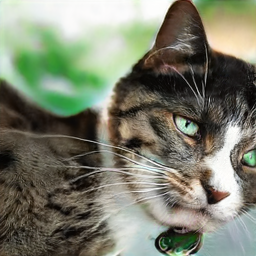

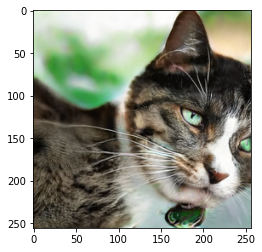

In [14]:
gen_random_show(model)

In [15]:
im_shape = perpre(model(gen_random(model.z_dim)))[0].size()
sideX, sideY, channels = im_shape

# Latent coordinate

Choose a place to start in BigGAN (it'll be a dog. Probably a hound lol)

In [16]:
BATCH_SIZE=16

In [17]:
class Pars(torch.nn.Module):
    def __init__(self, dims, batch_size=BATCH_SIZE):
        super(Pars, self).__init__()
        self.z = torch.nn.Parameter(torch.zeros(batch_size, dims).normal_(std=1).cuda())

    def forward(self):
      return self.z

torch.manual_seed(0)


lats = Pars(model.z_dim).cuda()
optimizer = torch.optim.Adam(lats.parameters(), .07)
eps = 0

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
t = perceptor.encode_text(tx.cuda()).detach().clone()

# Train

Train and generate samples

In [18]:
from tqdm.notebook import trange

In [19]:
NUM_EPOCHS = 200
PLOT_EVERY = NUM_EPOCHS/20

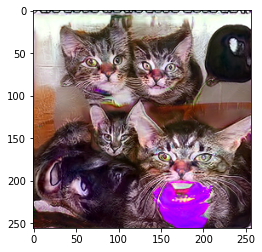

In [20]:
def checkin(loss, iter):
  best = torch.topk(loss, k=1, largest=False)[1].item()
  if not os.path.isdir(INPUT):
    os.mkdir(INPUT)
  gen_show(model, lats()[best].unsqueeze(0)).save(os.path.join(INPUT, f"{iter}.png"))

def ascend_txt():
  out = model(lats(), 1.0)

  cutn = out.size()[1]
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .95))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='nearest')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  into = nom((into + 1) / 2)
  iii = perceptor.encode_image(into)

  llls = lats()
  lat_l = torch.abs(1 - torch.std(llls, dim=1)).mean() + torch.abs(torch.mean(llls)).mean() + 4*torch.clamp_max(torch.square(llls).mean(), 1)

  for array in llls:
    mean = torch.mean(array)
    diffs = array - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0
    lat_l = lat_l + torch.abs(kurtoses) / llls.shape[0] + torch.abs(skews) / llls.shape[0]
  
  return lat_l, -100*torch.cosine_similarity(t, iii, dim=-1)

def train(i):
  optimizer.zero_grad()
  a, b = ascend_txt()
  loss = a + b.mean()
  loss.backward()
  optimizer.step()

  if i % PLOT_EVERY == 0:
    checkin(b, i)

for i in trange(NUM_EPOCHS):
  train(i)

# To run this section, please restart.
(in order to avoid a GPU MEMORY ERROR)

In [26]:
%cd /content/

/content


In [1]:
!python cli.py -n /content/stylegan2-ada-pytorch/stylegan2-cat-config-f.pkl -o devil

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
100% 200/200 [03:12<00:00,  1.04it/s]


In [23]:
if not os.path.exists('ffhq.pkl'):
  !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

--2021-03-22 00:01:16--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.226.123.41, 13.226.123.60, 13.226.123.66, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.226.123.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl.1’

ffhq.pkl.1          100%[===================>] 363.94M   113MB/s    in 3.2s    

2021-03-22 00:01:21 (113 MB/s) - ‘ffhq.pkl.1’ saved [381624121/381624121]



In [2]:
!python cli.py -n ffhq.pkl -o putin -i "The face of Putin" -b 8

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
100% 200/200 [03:08<00:00,  1.06it/s]


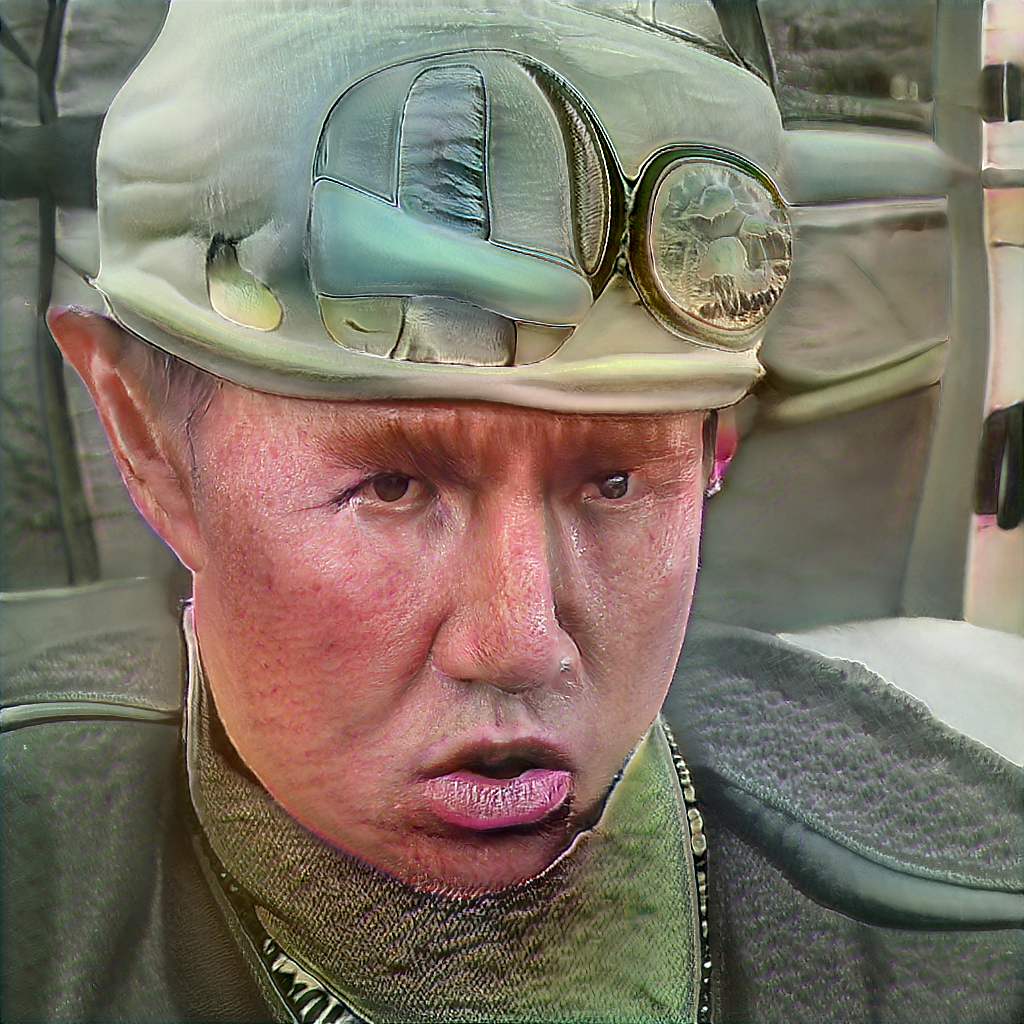

In [3]:
!python cli.py -n ffhq.pkl -o hacker -i "Hacker" -b 8 -e 100

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
100% 200/200 [03:06<00:00,  1.07it/s]


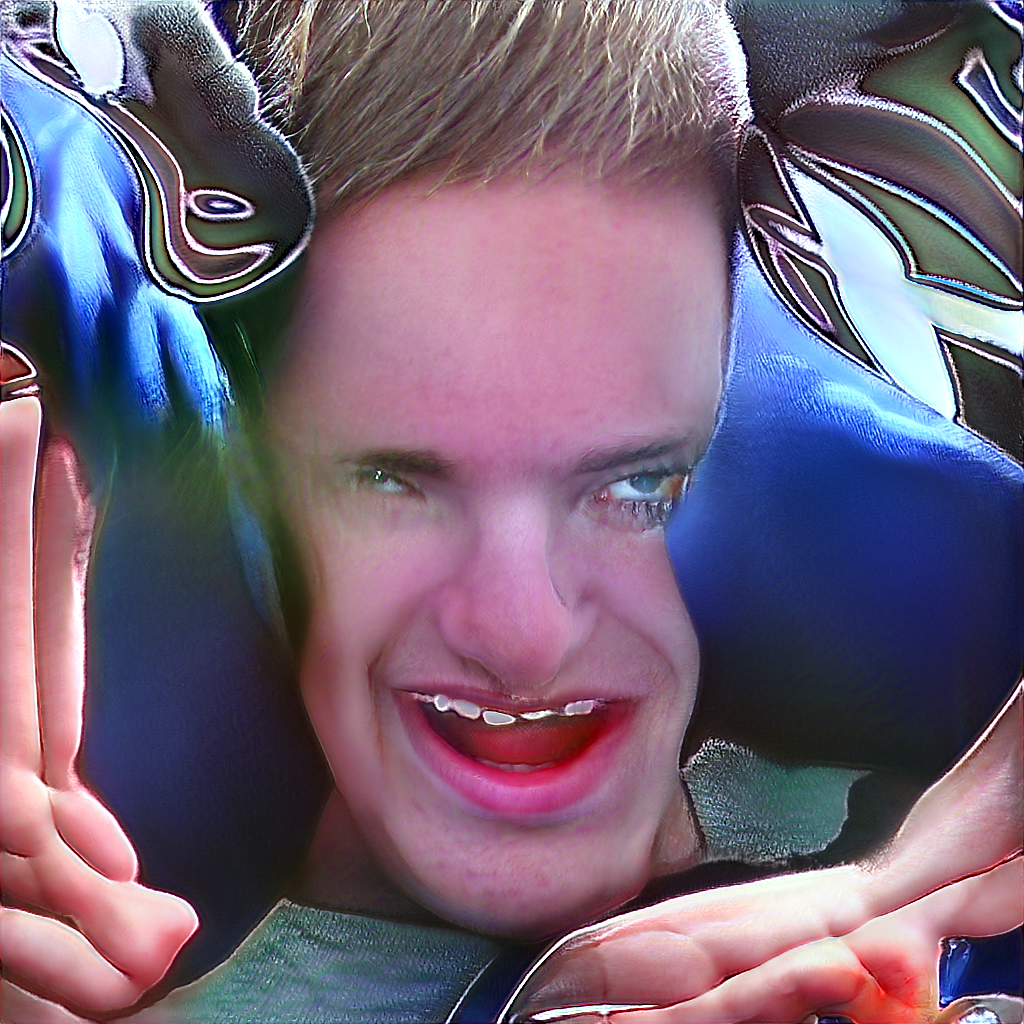

In [5]:
!python cli.py  --help

usage: stylegan2ada-image [-h] [-i TEXT] -n NETWORK [-e NUM_EPOCHS]
                          [-p TOTAL_PLOTS] [-b BATCH_SIZE] [-s STYLEGAN2_DIR]
                          [-c CLIP_DIR] [--seed SEED] [-o OUTDIR]

optional arguments:
  -h, --help            show this help message and exit
  -i TEXT, --text TEXT
  -n NETWORK, --network NETWORK
  -e NUM_EPOCHS, --num-epochs NUM_EPOCHS
  -p TOTAL_PLOTS, --total-plots TOTAL_PLOTS
  -b BATCH_SIZE, --batch-size BATCH_SIZE
  -s STYLEGAN2_DIR, --stylegan2-dir STYLEGAN2_DIR
  -c CLIP_DIR, --clip-dir CLIP_DIR
  --seed SEED
  -o OUTDIR, --outdir OUTDIR
